# Book Success Prediction using Machine Learning

Kathryn Hamilton and Frank Shannon

w207 Spring 2018

### Introduction

We would like to assess the relationship between the synopsis of a novel and its success by constructing a supervised machine learning classifier.

A book's synopsis, which is a couple paragraphs traditionally found on the back or inside cover of a book, serves to provide a brief explanation of the book's contents and any applicable critical acclaim of the the author. We would like to see if this information can be used to reliably predict whether or not the book will be successful. To do this, the team will study harness information found on Amazon.com, one of the world's largest e-commerce and cloud computing companies which, fittingly, started as an online bookstore.

We begin by importing the necessary libraries and setting up our document.

In [119]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import gzip
import re
import copy

# Set the seed so we can reproduce results
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

# SK-learn libraries for learning and evaluation
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from scipy import sparse as sp
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *

The data we will be using for this project come from two sources.

The first is an online repository of `.json` files compiled by Julian McAuley, Assistant Professor of Computer Science and Engineering at University of California, San Diego. These files, which can be found at http://jmcauley.ucsd.edu/data/amazon/ and will provides us with customer review information and product metadata [1, 2].

The second will be an API that we use to scrape book synopsis data from http://www.amazon.com/ using the list of product ID numbers included in the dataset of reviews.

Prof. McAuley's papers related to the Amazon dataset are as follows:

[1] R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016

[2] J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

### Import and Clean Metadata

We first explore the datasets provided by McAuley. These files are very large so we are looking to get rid of any information that will not be useful to us.

In addition, we will want to narrow down the data into a subset that seems well suited for the purpose of this project. For starters, this means selecting a category of books (Fiction, Travel, Money & Business, etc) that has enough examples and a good range of descriptive synopses.

At this point in the project our inputs and outputs are very loosely defined. It is hard to know specifically what we data will need in the end and if we even have it to begin with. So, some upfront exploration is a good first approach to begin forming a problem that we can reasonably solve.

In [3]:
# Unpackage McAuley metadata and reviews files, which are currently compressed .json files, using the code supplied on his site.

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0 
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

Import medatadata file (or alternatively upload a saved file).

In [4]:
# Use the above functions to upload McAuley's data file
metadata_import = getDF('meta_Books.json.gz')

In [2]:
# Alternatively, upload a pkl file that has already been processed
metadata = pd.read_pickle('metadata.pkl')

Let's take a look at the first few rows of the `metadata` file.

In [5]:
print "Length: ", len(metadata_import)   # print length of dataframe
metadata_import.head(n=5)   # print first 5 rows of dataframe

Length:  2370585


,asin,salesRank,imUrl,categories,title,description,related,price,brand
0,0001048791,{u'Books': 6334800},http://ecx.images-amazon.com/images/I/51MKP0T4...,[[Books]],"The Crucible: Performed by Stuart Pankin, Jero...",NaN,NaN,NaN,NaN
1,0001048775,{u'Books': 13243226},http://ecx.images-amazon.com/images/I/5166EBHD...,[[Books]],Measure for Measure: Complete &amp; Unabridged,William Shakespeare is widely regarded as the ...,NaN,NaN,NaN
2,0001048236,{u'Books': 8973864},http://ecx.images-amazon.com/images/I/51DH145C...,[[Books]],The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...","{u'also_viewed': [u'1442300191', u'9626349786'...",9.26,NaN
3,0000401048,{u'Books': 6448843},http://ecx.images-amazon.com/images/I/41bchvIf...,[[Books]],The rogue of publishers' row;: Confessions of ...,NaN,{u'also_viewed': [u'068240103X']},NaN,NaN
4,0001019880,{u'Books': 9589258},http://ecx.images-amazon.com/images/I/61LcHUdv...,[[Books]],Classic Soul Winner's New Testament Bible,NaN,"{u'also_viewed': [u'B003HMB5FC', u'0834004593'...",5.39,NaN


The `metadata` file describes each book.

Immediately, we see that there are several columns that will likely be of use to us:

* `asin`, which is the unique product identification number used by Amazon.
* `salesRank`, which describes the popularity of the book within the Amazon category "Books".
* `categories`, which describes the category and sub category that the book is classified in.

There are also several columns that are not of use to us:

* `imUrl`, which is a link to the product's photo.
* `related`, which is a list of similar products (might be useful in a more complex analysis, but we will ignore it for now)
* `brand`, which might describe affiliate companies such as the book's publisher

The first thing to do is process these fields to be the correct data type and organize the information suited to our project.

In [6]:
metadata = metadata_import.copy()   # create a duplicate data frame of the imported file

# convert column headers from unicode to ascii
metadata = metadata.rename(index=str,columns={u'asin':'asin', u'salesRank':'salesRank', u'imUrl':'imUrl', 
                                              u'categories':'categories', u'title':'title', u'description':'description',
                                              u'related':'related', u'price':'price', u'brand':'brand'})

metadata = metadata.drop(['imUrl','related','brand'],axis=1)   # drop unrelated columns

print "Length: ", len(metadata)   # print length of dataframe

Length:  2370585


It looks like we're working with almost 2.4 million books! This is a great dataset but is much to large for the scope of this project. We will need to find a way to select a subset of books to examine.

Let's fix the syntax of the `salesRank` column so it displays as simple integer. We will set the rank to 0 for any entry that is NaN-valued, or has a ranking in a cartegory other than "Books"

We found that many books were ranked in very specific sub categories, eg. #225 in Travel, Western Europe. As we don't have any key to unravel these rankings, we will have to see if we can do without those examples specifically.

In [3]:
metadata['salesRank'][metadata['salesRank'].isnull()] = 0   # set null sales rank values to zero
metadata['salesRank'] = metadata['salesRank'].astype(str)   # convert sales rank to string type
metadata['salesRank'][~metadata['salesRank'].str.contains('Books')] = 0   # set sales ranks not in 'Books' category to zero
metadata['salesRank'] = metadata['salesRank'].str.lstrip("{'Books': ")   # strip json/unicode characters from left
metadata['salesRank'] = metadata['salesRank'].str.rstrip("}")   # strip json/unicode characters from right
metadata['salesRank'] = metadata['salesRank'].astype('int64')   # set column to be integer type

Let's take a quick look at the distribution of `salesRank`. Remember that zero-valued rankings are equivalent to `NA`.

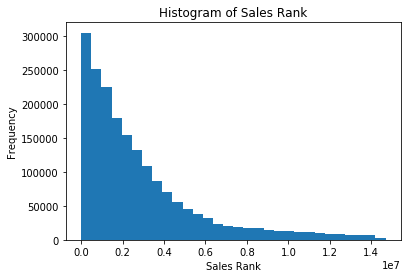

In [9]:
# make and print a histogram of sales rank with 30 bins
plt.hist(metadata['salesRank'][metadata['salesRank']!=0], bins=30)
plt.xlabel('Sales Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Sales Rank')
plt.show()

So it looks like we have a lot of highly ranked books and not so many lowly ranked book. This is probably a product of how the dataset was originally created. We also have a lot of books that do not have a ranking or are not ranked in the general "Books" category.

While we're at it, let's also take a look at the distribution of `price`. We see that it is roughly normal with a heavy right-skew.

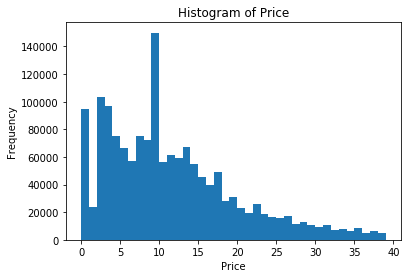

In [11]:
# make and print a histogram of price with 40 bins from $0 to $40
plt.hist(metadata['price'].dropna(axis=0), bins = range(0,40))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()

We see that we have a fair distribution of books.

Note that this graph continues to the right quite a ways. The maximum price in infact $999.99! As the price increases, it is likely that these "books" might be boxed sets, multiple volumes, special editions, or some other bizzare format that accounts for their price. Given a bit of investigation, we also found that we are dealing with both Kindle e-books and regular hard copy books, which is another limitation in using `price` as a factor in analysis as format plays a large role in determining price.

In [4]:
print "Maximum Price:", metadata['price'].max()   # display maximum price
print "Minimum Price:", metadata['price'].min()   # display minimum price
print "Mean Price:", round(metadata['price'].mean(),2)   # display (rounded) average price
print "Median Price:", metadata['price'].median()   # display median price

Maximum Price: 999.99
Minimum Price: 0.0
Mean Price: 17.63
Median Price: 10.54


As we found above, we have over two million titles to work with, which is great. We would like to narrow this down to a more workable size, likely by choosing a certain category or genre of books.

Let's check to see how many books fall into each category.

In [14]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
[['Books']],1940253
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica']]",8113
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",4060
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'Romantic Erotica']]",3189
"[['Books', 'Literature & Fiction', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction']]",3154
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'BDSM']]",3096
"[['Books', 'Reference', 'Words, Language & Grammar', 'Linguistics'], ['Kindle Store', 'Kindle eBooks', 'Reference', 'Words, Language & Grammar', 'Linguistics']]",1692
"[['Books', 'Literature & Fiction'], ['Books', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance']]",1599
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",1550


The above is a table of unique categories listed in descending number of books per category. We see that 1.9 million entries are uncategorized (their category is simply `Books`). However, this still leaves about 0.5 million books that have been categorized.

We see that there is an issue here with overcategorization. For example, we see that there are several of the above rows that fall under `Literature & Fiction` but have been specified further such that in their current format these entries are not bucketed together. 

The next logical step is to roll back these classifications to a higher level (for example, change `['Books', 'Literature & Fiction', 'Contemporary']` into simply `Literature & Fiction`), and then regroup the data.

We will do this by mapping the above list of unique categories to a new higher level list, and then using this map to alter the category of each individual item.

In [16]:
# Map Unique Categories to New, Higher Level Category
metadata['categories'] = metadata['categories'].astype(str)   # convert category information to string type
orig_categs = metadata.categories.values   # get a list of all categories
orig_categs = np.unique(orig_categs)   # Cut this down to only the unique categories

new_categs = copy.copy(orig_categs)   # Create a copy of this list

for i in range(0,len(new_categs)):   # For each unique category
    text = re.sub('[^a-zA-Z&, ]+', '', str(new_categs[i]))   # Remove all the extra symbols and space
    text = text.split(",")   # Split by comma
    if len(text)>1:   # If there is more than one element (category contains a sub category)
        new_categs[i] = text[1].lstrip(' ')   # New category name is the first sub category
    else:   # If there is no sub category
        new_categs[i] = 'Books'   # New category name is simply "books"

print "New, simpler categories are: \n\n", np.unique(new_categs)   # print new categories

New, simpler categories are: 

['Arts & Photography' 'Biographies & Memoirs' 'Books' 'Business & Money'
 'Calendars' 'Childrens Books' 'Christian Books & Bibles'
 'Comics & Graphic Novels' 'Computers & Technology' 'Cookbooks' 'Crafts'
 'Crafts & Sewing' 'Diapering' 'Education & Teaching'
 'Engineering & Transportation' 'Exterior Accessories' 'Gay & Lesbian'
 'Health' 'Health & Baby Care' 'History' 'Humor & Entertainment' 'Law'
 'Literature & Fiction' 'Medical Books' 'Mystery' 'New'
 'Parenting & Relationships' 'Politics & Social Sciences' 'Reference'
 'Religion & Spirituality' 'Romance' 'Science & Math'
 'Science Fiction & Fantasy' 'SelfHelp' 'Sports & Outdoors'
 'Teen & Young Adult' 'Travel']


These categories look to be at a great level for our analysis!

Now have a way to map the original categories into the list above. Some examples of this mapping are seen below.

In [19]:
pd.DataFrame(np.column_stack((orig_categs, new_categs)), columns = ("OldLabel","NewLabel")).head(n=10)

,OldLabel,NewLabel
0,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
1,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
2,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
3,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
4,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
5,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
6,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
7,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
8,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
9,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing


Let's replace the categories in the dataframe according to the mapping.

In [49]:
metadata['categories'] = metadata['categories'].astype(str)   # convert categories from objects to strings
for i in range(0, len(orig_categs)):   # for each original category
    # recategorize all books in that category to the new higher level category
    metadata['categories'] = metadata['categories'].replace(str(orig_categs[i]), str(new_categs[i]))

We've done a lot of heavy computation (this took 10+ hours to run) so let's make sure we don't lose it.

In [46]:
metadata_backup = metadata.copy()   # create copy in kernel
metadata.to_pickle('metadata.pkl')   # save to pickle file

Now let's take another look at how many examples we have in each category.

In [4]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1940253
Literature & Fiction,200791
Childrens Books,25424
Christian Books & Bibles,22470
Business & Money,18174
Biographies & Memoirs,18145
Health,18036
Cookbooks,11678
Gay & Lesbian,11533


Amazing! Now we have plenty of examples in each category.

Unfortunately, very few examples in these categories have information in the `salesRank` field. So we will not be able to reliably use the `salesRank` field.

In [5]:
#  looking only at books with non-zero sales rank: convert to string and then group, sort and display
metadata2 = metadata[metadata['salesRank'] != 0]
metadata2.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1890996
Health,6
Sports & Outdoors,4
Crafts,2
Reference,2
Arts & Photography,1
Childrens Books,1
Computers & Technology,1
New,1


Under further investigation we found that this was because the `salesRank` field was either empty for examples that had been categorized further than `Books`, or showed a salesRank within a subcategory of `Books` that was far too specific to reasonably unravel in the timeline of this project. So we have chosen to go ahead without using `salesRank`. In a future analysis, it would be really interesting to try to predict sales rank based on book jacket description. Unfortunately, it looks like we will need to operationalize the definition of "success" a bit differently.

Regardless, we are now at a good place to downsize the amount of data we are working with by selecting a few categories to continue with for this project.

We are looking for categories that will have meaningful keywords in the book's description that are common across the category in general. This means we want something based in fact rather than fiction.

We also want to pick a category with enough variance that books do not tend to duplicate content and thus descriptions still contain a slightly subjective element. For example, we might run into a problem in the Reference category wherein multiple calculus textbooks might exist with virtually the same descriptions and content. Politics & Social Sciences, on the other hand, might have enough common foundational ground while still being subject to opinions and other variances.

We have decided to move forward with the `Business & Money` category:

In [7]:
busi_data = metadata[metadata['categories'] == 'Business & Money']   # extract Business & Money books only
print "Length: ", len(busi_data)   # print number of books

Length:  18174


We have about 18,000 books to work with. Let's look at a few rows of the dataframe to get reacquainted with where we are.

In [8]:
busi_data.head(n=5)   # print first 5 rows of dataframe

,asin,salesRank,categories,title,description,price
962599,0976963094,0,Business & Money,Dave Ramsey's ACT Your Wage! Board Game,Get gazelle intense with this new board game f...,20.27
1769347,9810579357,0,Business & Money,The Art and Science of Entrepreneurship,"In the Art and Science of Entrepreneurship, In...",NaN
1775923,B0000547EU,0,Business & Money,NaN,Known as the father of contemporary negotiatin...,NaN
1775933,B00005MCQC,0,Business & Money,NaN,NaN,NaN
1775934,B00005MB6I,0,Business & Money,NaN,NaN,NaN


We still have missing fields to contend with, but this is a good start.

### Import and Clean Review Data

Now let's turn our attention to the other dataset provided by McAuley. 

This set contains over 22 million star rating tuples (`['user','asin','rating','timestamp']`) for the same books referenced in the `metadata` dataset. This set has already been cleaned and deduplicated.

In [9]:
reviews_import = pd.read_csv('ratings_Books.csv', names = ['user','asin','rating','timestamp'])   # import the file

In [10]:
print "Length: ", len(reviews_import)   # print length of dataframe
reviews_import.head(n=5)   # print first 5 rows of dataframe

Length:  22507155


,user,asin,rating,timestamp
0,AH2L9G3DQHHAJ,0000000116,4.0,1019865600
1,A2IIIDRK3PRRZY,0000000116,1.0,1395619200
2,A1TADCM7YWPQ8M,0000000868,4.0,1031702400
3,AWGH7V0BDOJKB,0000013714,4.0,1383177600
4,A3UTQPQPM4TQO0,0000013714,5.0,1374883200


There are over 22.5 million individual ratings in the data set that show who ranked which book at what time.

We only need `asin` and `rating` for the purpose of this project. Additionally, we can drop all of the rows that do not reference a book in `Business & Money`.

In [12]:
reviews = reviews_import.drop(labels = ['user','timestamp'], axis = 'columns')   #drop user and timestamp columns
reviews = reviews[reviews['asin'].isin(busi_data['asin'])]   # drop books not in Business & Money
print "Length: ", len(reviews)   # print length of dataframe

Length:  96940


So there are almost 100,000 ratings that are specific to the books we are working with. Great!

Let's compile the ratings for each book into a list, insert them into the `metadata` dataframe, then take a look to see what we have done so far.

In [13]:
busi_data = busi_data.reset_index(drop=True)   # reset index so we count 0, 1, 2, 3... again
busi_data['ratings'] = np.nan  # make a new column called ratings and set it to nan for now
busi_data['ratings'] = busi_data['ratings'].astype(object)   # convert the column into object type
for i in range(0,len(busi_data)):   # for each Business & Money book
    rev_sub = reviews[reviews['asin'] == busi_data.iloc[i]['asin']]   # get reviews that pertain to this book
    revs = np.asarray(rev_sub['rating'])   # pull out the array of five-star ratings from these reviews
    busi_data.set_value(i,'ratings', revs)   # insert this array into the Business & Money metadata dataframe

In [14]:
busi_data.to_pickle('busi_data.pkl')   # save to pickle file
busi_data.head(n=10)   # show first 10 lines

,asin,salesRank,categories,title,description,price,ratings
0,0976963094,0,Business & Money,Dave Ramsey's ACT Your Wage! Board Game,Get gazelle intense with this new board game f...,20.27,"[4.0, 4.0, 5.0, 2.0, 5.0, 4.0, 5.0, 5.0, 5.0, ..."
1,9810579357,0,Business & Money,The Art and Science of Entrepreneurship,"In the Art and Science of Entrepreneurship, In...",NaN,[5.0]
2,B0000547EU,0,Business & Money,NaN,Known as the father of contemporary negotiatin...,NaN,[5.0]
3,B00005MCQC,0,Business & Money,NaN,NaN,NaN,"[4.0, 4.0, 3.0]"
4,B00005MB6I,0,Business & Money,NaN,NaN,NaN,"[1.0, 5.0]"
5,B00005MB8F,0,Business & Money,NaN,NaN,NaN,"[1.0, 1.0]"
6,B00005MB9S,0,Business & Money,NaN,NaN,NaN,[1.0]
7,B00005MFBG,0,Business & Money,NaN,NaN,NaN,"[1.0, 1.0]"
8,B00005MFAJ,0,Business & Money,NaN,NaN,NaN,[1.0]
9,B00005N9CI,0,Business & Money,NaN,Darrell Rigby is a Director in the Boston offi...,NaN,"[4.0, 4.0, 1.0]"


We now have a new column that shows a list of ratings associated with each book.

Note that there are quite a few books that contain only one or two ratings. If possible, it might be wise to remove these books from consideration as having only one or two data points is not very reliable. For example, a book with one five-star rating could quickly become a three-star book if someone were to come along and leave a one-star review.

On the other hand, removing books with only a few ratings may skew the results in another way, as poor ratings are correlated with poor readership (people tend not to buy books with poor ratings and thus there are less people available to rate them). However, as `rating` will be one of the most important variables determining success, the risk may be worth the extra information gained by requiring a minimum number of ratings.

Alternatively, the team could use both "rating" and the "number of ratings" as variables in the analysis. This might allow for error to be attributed where the number of ratings are low.

Regardless, the team is also limited by how many examples are available with a minimum number of ratings.

In [39]:
# Upload busi_data if we have refreshed the kernel
busi_data = pd.read_pickle('busi_data.pkl')

In [40]:
# Count how many books have a minimum number of ratings

print "Number of examples that have a minimum number of ratings:\n"

# drop unnecessary columns
busi_nums = busi_data.drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()
busi_nums.columns = ['All']   # rename this column

# for each number of ratings >0 to >14, drop books that don't meet this condition and count how many remain
busi_nums['> 0'] = busi_data[busi_data['ratings'].str.len() > 0].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 1'] = busi_data[busi_data['ratings'].str.len() > 1].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 2'] = busi_data[busi_data['ratings'].str.len() > 2].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 3'] = busi_data[busi_data['ratings'].str.len() > 3].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 4'] = busi_data[busi_data['ratings'].str.len() > 4].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 5'] = busi_data[busi_data['ratings'].str.len() > 5].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 6'] = busi_data[busi_data['ratings'].str.len() > 6].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 7'] = busi_data[busi_data['ratings'].str.len() > 7].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 8'] = busi_data[busi_data['ratings'].str.len() > 8].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 9'] = busi_data[busi_data['ratings'].str.len() > 9].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 10'] = busi_data[busi_data['ratings'].str.len() > 10].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 11'] = busi_data[busi_data['ratings'].str.len() > 11].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 12'] = busi_data[busi_data['ratings'].str.len() > 12].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 13'] = busi_data[busi_data['ratings'].str.len() > 13].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
busi_nums['> 14'] = busi_data[busi_data['ratings'].str.len() > 14].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']

print busi_nums # print results

Number of examples that have a minimum number of ratings:

                    All    > 0    > 1   > 2   > 3   > 4   > 5   > 6   > 7  \
categories                                                                  
Business & Money  18174  18048  10838  7739  6040  4891  4057  3448  2986   

                   > 8   > 9  > 10  > 11  > 12  > 13  > 14  
categories                                                  
Business & Money  2588  2278  1991  1757  1578  1411  1267  


So it looks like there is a fair amount of data to work with if we want to restrict by minimum number of ratings.

It might be interesting to explore the impact of having many vs few ratings on the accuracy of the learning algorithms, even if requiring more ratings decreases the sample size. For example, how accurate is the average rating when there are only a couple ratings?

Scraping data is a time consuming process, and we still need to scrape book jacket descriptions from Amazon.com with the books that we proceed with, so we will also need to select a subset that is appropriately sized. These sets will then be partitioned into development, training, and test sets.

Hence, we have decided to move forward with two different datasets:

* "`Many`" - 1000 examples with at least 3 ratings from each of the four categories
* "`Few`" - 300 examples with at least 10 ratings from each of the four categories

Note that this selection is mostly arbitrary. At face value, though, it seems to be well suited for exploring the relationship between total examples and minimum number of ratings, while still providing a sufficient amount of each.

We have also found while scraping data that roughly 5% of the books in the dataset no longer exist on Amazon.com. To counteract this, we will size our subsets up a bit to 1250 and 350, respectively. We will then proceed with scraping description data for these items, and then downsize to a random 1000 and 300 successfully scraped books when the process is complete.

In [250]:
# Pull out the Many dataset (>= 3 ratings) and then randomly select 1200 Business & Money books, reset index
busi_many = busi_data[busi_data['ratings'].str.len() > 2]
busi_many = busi_many[busi_many['categories'] == 'Business & Money'].sample(n = 1250)
busi_many = busi_many.reset_index(drop=True)

# Pull out the Few dataset (>= 10 ratings) and then randomly select 350 Business & Money books, reset index
busi_few = busi_data[busi_data['ratings'].str.len() > 9]
busi_few = busi_few[busi_few['categories'] == 'Business & Money'].sample(n = 350)
busi_few = busi_few.reset_index(drop=True)

# Check the sizes to make sure we did it right
print "Many: ", len(busi_many)
print "Few: ", len(busi_few)

Many:  1250
Few:  350


Now let's save these so we can pull them up again if needed and so that we can scrape externally.

In [253]:
# Save the dataframes and asin series of each so that we can use externally to scrape
busi_many.to_pickle('busi_many.pkl')
busi_many['asin'].to_csv('busi_many_scrape.csv')

busi_few.to_pickle('busi_few.pkl')
busi_few['asin'].to_csv('busi_few_scrape.csv')

### Scrape Description Data

I used a tool called Octoparse (https://www.octoparse.com/) to scrape information from Amazon.

It's a program that you install on your local machine. I fed it a list of urls in the form `https://www.amazon.com/dp/<asin>` and specified the program to extract the title, price, and description field of each product. Wherever the field was missing, or in cases that the book no longer exist, the program left the field blank.

I then checked the results and saved them as a `.csv` file.

Now we just need to upload the results, merge it into the dataframe we have by `asin`, and then downsize to our target lengths of 1000 and 300 for the `Many` (>= 3 reviews) and `Few` (>= 10 reviews) datasets, respectively.

In [128]:
# Upload the busi_many and busi_few files if we no longer have them locally on this kernel
busi_many = pd.read_pickle('busi_many.pkl')
busi_few = pd.read_pickle('busi_few.pkl')
busi_data = pd.read_pickle('busi_data.pkl')

# Upload the scraped information
busi_many_scraped = pd.read_csv('busi_many_scraped.csv')   
busi_few_scraped = pd.read_csv('busi_few_scraped.csv')   

Let's take a look at the format of the scraped data.

In [129]:
busi_many_scraped

,index,asin,url,title,price,description
0,0,B0076NXC2M,https://www.amazon.com/dp/B0076NXC2M,Land That Job! How to Write a Perfect Resume a...,2.99,**AMAZON BEST SELLER**Hi Friends!My name is St...
1,1,B00K49B0ZG,https://www.amazon.com/dp/B00K49B0ZG,Debt: Debt Guide To How To Get Out Of Debt Wit...,2.99,Debt Guide To How To Get Out Of Debt With Prov...
2,2,B00JZ4XJWI,https://www.amazon.com/dp/B00JZ4XJWI,NaN,NaN,NaN
3,3,B004P1JMOK,https://www.amazon.com/dp/B004P1JMOK,Insights into the Global Financial Crisis,0.99,The global financial crisis of 2007�2009 is un...
4,4,B0077QR5DU,https://www.amazon.com/dp/B0077QR5DU,NaN,NaN,NaN
5,5,B00KP2KL3E,https://www.amazon.com/dp/B00KP2KL3E,Self-Publishing Masterclass - Mile-High Word-C...,3.99,Createspace and Kindle Self-Publishing Masterc...
6,6,B0057WTF4I,https://www.amazon.com/dp/B0057WTF4I,NaN,NaN,NaN
7,7,B00JIGIET6,https://www.amazon.com/dp/B00JIGIET6,Productivity Hacks: 88 Key Habits on How to Be...,2.99,Learn 88 Productivity Hacks to take control of...
8,8,B00J5RH4M6,https://www.amazon.com/dp/B00J5RH4M6,27 Facebook Marketing MISTAKES Businesses Make...,2.99,-=-=-=-=-=-=-=-=- Amazon #1 Best Seller�Advert...
9,9,B00JXLCZ3C,https://www.amazon.com/dp/B00JXLCZ3C,INVESTING: A Complete Beginners Guide to Inves...,0.99,REVEALED: Investing Secrets for Beginners to B...


In [130]:
busi_few_scraped

,index,asin,url,title,price,description
0,0,B00KVSWX7Y,https://www.amazon.com/dp/B00KVSWX7Y,Long Put Ladder Spread: A Simple Options Tradi...,0.99,"A Simple, Proven Options Trading Strategy For ..."
1,1,B00CSJ9WPK,https://www.amazon.com/dp/B00CSJ9WPK,Dhandha: How Gujratis Do Business,3.99,"Dhandha, meaning business, is a term often use..."
2,2,B0096IWU5U,https://www.amazon.com/dp/B0096IWU5U,"Diary of a Bad, Bad Bookkeeper: A Cautionary ...",2.99,What People are Saying About The Diary of a Ba...
3,3,B00866873W,https://www.amazon.com/dp/B00866873W,A Guide to Starting and Developing a New Busin...,0.00,"A short guide developed by Lord Young, the Pri..."
4,4,B00H1QQJQA,https://www.amazon.com/dp/B00H1QQJQA,Foreign Invaders: An Autoimmune Disease Journe...,3.99,"""A must-read for anyone dealing with health is..."
5,5,B00JYK3A8G,https://www.amazon.com/dp/B00JYK3A8G,Procrastination: Stop Procrastination NOW - Th...,2.99,Discover How To Stop Procrastinating For Life!...
6,6,B00IGZOSBS,https://www.amazon.com/dp/B00IGZOSBS,100% Focused: 25 Great Ways To Improve Your Fo...,0.99,The minds of successful people are well organi...
7,7,B00D6M91IG,https://www.amazon.com/dp/B00D6M91IG,How to Start a Creative Business - A Glossary ...,0.00,This invaluable glossary of terms can be used ...
8,8,B00GBGW5VO,https://www.amazon.com/dp/B00GBGW5VO,The NEW Game of Selling,2.99,"In The NEW Game of Selling�, sales master Mitc..."
9,9,B00850W834,https://www.amazon.com/dp/B00850W834,NaN,NaN,NaN


We can see some rows contain `NaN`, which are books that no longer exist and so information could not be scraped.

Now we need to do a bit of work to merge the dataframes together and reduce down to the columns that we will actually use in a format that we want.

In [131]:
# Merge Many on asin, drop irrelevant columns, rename remaining columns, drop rows w/ empty fields, resize to 1000, reindex
busi_many = pd.merge(busi_many_scraped, busi_data, on="asin")
busi_many = busi_many.drop(['index','url','salesRank','title_y','description_y','price_y'], axis = 1)
busi_many = busi_many.rename(index=str,columns={'title_x':'title', 'price_x':'price', 'description_x':'description'})
busi_many = busi_many.dropna(axis=0)
busi_many = busi_many.sample(n = 1000)
busi_many = busi_many.reset_index(drop=True)

# Merge Few on asin, drop irrelevant columns, rename remaining columns, drop rows w/ empty fields, resize to 300, reindex
busi_few = pd.merge(busi_few_scraped, busi_data, on="asin")
busi_few = busi_few.drop(['index','url','salesRank','title_y','description_y','price_y'], axis = 1)
busi_few = busi_few.rename(index=str,columns={'title_x':'title', 'price_x':'price', 'description_x':'description'})
busi_few = busi_few.dropna(axis=0)
busi_few = busi_few.sample(n = 300)
busi_few = busi_few.reset_index(drop=True)

Let's double check the sizes quickly and take a look to see what we have.

In [132]:
# Check the sized
print "Many: ", len(busi_many)
print "Few: ", len(busi_few)

Many:  1000
Few:  300


In [133]:
busi_many

,asin,title,price,description,categories,ratings
0,B0084AA9KE,Habitudes for Communicators (Habitudes: Images...,9.99,"More robust than the other Habitudes, this new...",Business & Money,"[5.0, 5.0, 5.0, 5.0]"
1,B0058DITVG,SEO Examples: 10 Illustrative SEO Writing Samples,9.99,ABOUT THE AUTHORMy name is Yuwanda Black and I...,Business & Money,"[4.0, 5.0, 5.0]"
2,B008W37YX8,"Habits for your Dream Life, Overcome Obstacles...",2.99,WARNING: Learn how to make MORE money with LES...,Business & Money,"[3.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, ..."
3,B00L4KMO04,PR Secrets No One Will Ever Tell You: How Infl...,5.99,Want to monetize your blog by working with bra...,Business & Money,"[5.0, 5.0, 5.0]"
4,B00KDY5WVU,Long Call Ladder Spread: A Simple Options Trad...,0.99,"A Simple, Proven Options Trading Strategy For ...",Business & Money,"[5.0, 5.0, 4.0]"
5,B006C5ZLXS,Tales of a White Trash Landlord,8.99,"Tales of a White Trash Landlord: Putting the ""...",Business & Money,"[5.0, 5.0, 5.0, 5.0]"
6,B00D7HLOGM,"KLOUT SCORE: Social Media Influence, How to G...",2.99,Klout + Social Media = InfluenceFind out why K...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
7,B00IFF9M0G,Why Nudge?: The Politics of Libertarian Patern...,7.62,Based on a series of pathbreaking lectures giv...,Business & Money,"[4.0, 4.0, 1.0, 5.0]"
8,B004FEFAMK,How to Make Money and Bigger Tips as a Waitress,2.99,Excellent advice from a seasoned waitress in a...,Business & Money,"[1.0, 3.0, 5.0, 5.0]"
9,B00CKF744S,Local Search Marketing Driving More Customers...,2.99,Local search marketing is a local business�s b...,Business & Money,"[5.0, 5.0, 5.0]"


In [134]:
busi_few

,asin,title,price,description,categories,ratings
0,B008HW8YJC,Becoming an Entrepreneur (Online Career Plans ...,0.99,"Are you floundering in your job, wishing you h...",Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ..."
1,B00HCDGZ6Q,Binary Options University: How to make money t...,2.99,Learn to make money from home trading binary o...,Business & Money,"[1.0, 5.0, 2.0, 5.0, 4.0, 1.0, 5.0, 5.0, 2.0, ..."
2,B00KERY8KM,Choosing Delight: True Life Stories of Quittin...,2.99,In Choosing Delight Leyla Day presents the ins...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
3,B00JYK3A8G,Procrastination: Stop Procrastination NOW - Th...,2.99,Discover How To Stop Procrastinating For Life!...,Business & Money,"[1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
4,B00KOVMEOU,How To Network At Networking Events: 5 Simple ...,0.99,Interested in learning how to network more eff...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
5,B00KJMWFAW,Debt Free For Good: An Easy Strategy To Help Y...,0.99,"Over 6500 Downloads To DateDebt, for some, is ...",Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
6,B005SYVOK8,LinkedIn Insider Secrets to your Job Search,2.99,Finding a Job on LinkedIn can be challenging w...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, ..."
7,B00AQ5DYMA,Saving Money in the Kitchen: Frugal Cooking Ti...,2.99,Louise Hill is a mom to five and grandmother t...,Business & Money,"[4.0, 2.0, 4.0, 5.0, 5.0, 1.0, 5.0, 1.0, 3.0, ..."
8,B00KRV7J38,Management Unlimited: The Premium Leadership S...,2.99,Learn How To Develop The Best Leadership And M...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, ..."
9,B00L2M7V7A,Creativity: Creative Block Solutions to Rebuil...,2.99,Welcome to your 7-days journey to creativity!3...,Business & Money,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."


### Machine Learning

Great! Now we have some data to work with.

Okay, so we want to do some machine learning. Let's first talk a bit about what we want to achieve.

The purpose of this investigation is to explore the relationship between book jacket description and book success. While there are many factors that go into a person deciding to purchase a book, such as word of mouth recommendations, cover art, and notability of the author, we want to focus on book jacket descriptions in particular.

Suppose someone is in a bookstore browing books or surfing through Amazon. They read the book jacket description to get a feel for what the contents of the book will be, any critical acclaim of the author, and perhaps, in the case of Business & Money books for example, how the book might impact the reader's daily livelihood.

It is reasonable to assume that given a particular category of books there might be certain keywords or phrases included in a book jacket description that might entice a prosepective reader to buy it.

While we don't have sales information to work with (sales ranking was not a reliable information source), we do have rating information on a five star scale. Ratings and sales do share their own relationship, as people tend not to buy products that are rated poorly. However, it might also make sense that poorly writen books that recieve poor reviews also have poorly written book jacket descriptions, and vice versa.

So operationally, let's set our first goal at predicting five-star rating using book jacket text.

To create a list of classes, let's make a new column that has the rounded average star rating. This will be a value in `[1.0, 2.0, 3.0, 4.0, 5.0]` (note that Amazon does not allow zero-star ratings).

In [135]:
# Calculate average ratings for Many dataset
avg_ratings = []   # create an empty list to store average rating
for i in range(0,len(busi_many)):   # for each book in the Many dataset
    avg_ratings.append(round(np.mean(busi_many['ratings'][i])))   # calculate average rating and append to list
busi_many['rate'] = avg_ratings   # store list as new column in dataframe

# Calculate average ratings for Many dataset
avg_ratings = []   # create an empty list to store average rating
for i in range(0,len(busi_few)):   # for each book in the Few dataset
    avg_ratings.append(round(np.mean(busi_few['ratings'][i])))   # calculate average rating and append to list
busi_few['rate'] = avg_ratings   # store list as new column in dataframe

In [136]:
busi_many   # print Many dataframe

,asin,title,price,description,categories,ratings,rate
0,B0084AA9KE,Habitudes for Communicators (Habitudes: Images...,9.99,"More robust than the other Habitudes, this new...",Business & Money,"[5.0, 5.0, 5.0, 5.0]",5.0
1,B0058DITVG,SEO Examples: 10 Illustrative SEO Writing Samples,9.99,ABOUT THE AUTHORMy name is Yuwanda Black and I...,Business & Money,"[4.0, 5.0, 5.0]",5.0
2,B008W37YX8,"Habits for your Dream Life, Overcome Obstacles...",2.99,WARNING: Learn how to make MORE money with LES...,Business & Money,"[3.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, ...",4.0
3,B00L4KMO04,PR Secrets No One Will Ever Tell You: How Infl...,5.99,Want to monetize your blog by working with bra...,Business & Money,"[5.0, 5.0, 5.0]",5.0
4,B00KDY5WVU,Long Call Ladder Spread: A Simple Options Trad...,0.99,"A Simple, Proven Options Trading Strategy For ...",Business & Money,"[5.0, 5.0, 4.0]",5.0
5,B006C5ZLXS,Tales of a White Trash Landlord,8.99,"Tales of a White Trash Landlord: Putting the ""...",Business & Money,"[5.0, 5.0, 5.0, 5.0]",5.0
6,B00D7HLOGM,"KLOUT SCORE: Social Media Influence, How to G...",2.99,Klout + Social Media = InfluenceFind out why K...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",5.0
7,B00IFF9M0G,Why Nudge?: The Politics of Libertarian Patern...,7.62,Based on a series of pathbreaking lectures giv...,Business & Money,"[4.0, 4.0, 1.0, 5.0]",4.0
8,B004FEFAMK,How to Make Money and Bigger Tips as a Waitress,2.99,Excellent advice from a seasoned waitress in a...,Business & Money,"[1.0, 3.0, 5.0, 5.0]",4.0
9,B00CKF744S,Local Search Marketing Driving More Customers...,2.99,Local search marketing is a local business�s b...,Business & Money,"[5.0, 5.0, 5.0]",5.0


In [137]:
busi_few   # print Few dataframe

,asin,title,price,description,categories,ratings,rate
0,B008HW8YJC,Becoming an Entrepreneur (Online Career Plans ...,0.99,"Are you floundering in your job, wishing you h...",Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ...",5.0
1,B00HCDGZ6Q,Binary Options University: How to make money t...,2.99,Learn to make money from home trading binary o...,Business & Money,"[1.0, 5.0, 2.0, 5.0, 4.0, 1.0, 5.0, 5.0, 2.0, ...",4.0
2,B00KERY8KM,Choosing Delight: True Life Stories of Quittin...,2.99,In Choosing Delight Leyla Day presents the ins...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",5.0
3,B00JYK3A8G,Procrastination: Stop Procrastination NOW - Th...,2.99,Discover How To Stop Procrastinating For Life!...,Business & Money,"[1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",5.0
4,B00KOVMEOU,How To Network At Networking Events: 5 Simple ...,0.99,Interested in learning how to network more eff...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",5.0
5,B00KJMWFAW,Debt Free For Good: An Easy Strategy To Help Y...,0.99,"Over 6500 Downloads To DateDebt, for some, is ...",Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",5.0
6,B005SYVOK8,LinkedIn Insider Secrets to your Job Search,2.99,Finding a Job on LinkedIn can be challenging w...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, ...",4.0
7,B00AQ5DYMA,Saving Money in the Kitchen: Frugal Cooking Ti...,2.99,Louise Hill is a mom to five and grandmother t...,Business & Money,"[4.0, 2.0, 4.0, 5.0, 5.0, 1.0, 5.0, 1.0, 3.0, ...",4.0
8,B00KRV7J38,Management Unlimited: The Premium Leadership S...,2.99,Learn How To Develop The Best Leadership And M...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, ...",5.0
9,B00L2M7V7A,Creativity: Creative Block Solutions to Rebuil...,2.99,Welcome to your 7-days journey to creativity!3...,Business & Money,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",5.0


Next, let's check how many books ended up in each "class", the rounded average star rating.

In [138]:
print "Number of books per class in the Many dataset (1000 books with >= 3 ratings)"
# count number of books in each class
busi_many.drop(['title','price','description','categories','ratings'], axis = 1).groupby('rate').count()

Number of books per class in the Many dataset (1000 books with >= 3 ratings)


,asin
rate,
1.0,6
2.0,16
3.0,71
4.0,344
5.0,563


In [139]:
print "Number of books per class in the Many dataset (300 books with >= 10 ratings)"
# count number of books in each class
busi_few.drop(['title','price','description','categories','ratings'], axis = 1).groupby('rate').count()

Number of books per class in the Many dataset (300 books with >= 10 ratings)


,asin
rate,
2.0,3
3.0,16
4.0,127
5.0,154


We have a good split of five- and four-star books, but not a lot of three-star or less books.

Our results will be most powerful in the five- and four-star book categories, and the other classes will be unreliable. What we could do, however, is group the three-star and below books together to make it a larger and more powerful class.

Let's do that. We set any one- or two-star book to be a three-star book, where three-star now means three-star and below.

In [140]:
busi_many['rate'] = busi_many['rate'].astype(str)   # convert rate information to a string
busi_few['rate'] = busi_few['rate'].astype(str)   # convert rate information to a string

for i in range(0,len(busi_many)):   # for each book in the Many dataframe
    if busi_many.iloc[i]['rate'] in ['1.0','2.0','3.0']:   # if a one-, two-, or three-star book
        busi_many.set_value(i, 'rate', '3.0 & Below')   # change class to '3.0 & Below'

for i in range(0,len(busi_few)):   # for each book in the Few dataframe
    if busi_few.iloc[i]['rate'] in ['1.0','2.0','3.0']:   # if a one-, two-, or three-star book
        busi_few.set_value(i, 'rate', '3.0 & Below')   # change class to '3.0 & Below'

Now let's check the spread again.

In [141]:
print "Number of books per class in the Many dataset (1000 books with >= 3 ratings)"
# count number of books in each class
busi_many.drop(['title','price','description','categories','ratings'], axis = 1).groupby('rate').count()

Number of books per class in the Many dataset (1000 books with >= 3 ratings)


,asin
rate,
3.0 & Below,93
4.0,344
5.0,563


In [142]:
print "Number of books per class in the Many dataset (300 books with >= 10 ratings)"
# count number of books in each class
busi_few.drop(['title','price','description','categories','ratings'], axis = 1).groupby('rate').count()

Number of books per class in the Many dataset (300 books with >= 10 ratings)


,asin
rate,
3.0 & Below,19
4.0,127
5.0,154


This looks a bit better. We now have three classes to work with and a reasonable amount of books per class.

In [143]:
# Our classes are as follows
classes = ['3.0 & Below','4.0','5.0']

Now it's time to partition our datasets out into a training, development and test set. We will use a 80:10:10 split.

In [144]:
print "Training, Development, and Test Dataset Sizes:\n"

# partition Many dataset description into training, dev, and test data sets using 80:10:10 split
many_train = np.copy(np.asarray(busi_many['description'][0:800]))
many_dev = np.copy(np.asarray(busi_many['description'][800:900]))
many_test = np.copy(np.asarray(busi_many['description'][900:1000]))

# partition Many dataset ratings into training, dev, and test label sets using 80:10:10 split
many_train_labels = np.copy(np.asarray(busi_many['rate'][0:800]))
many_dev_labels = np.copy(np.asarray(busi_many['rate'][800:900]))
many_test_labels = np.copy(np.asarray(busi_many['rate'][900:1000]))

print "For the Many Data set: ", len(many_train), len(many_dev), len(many_test)  # print lengths to double check

# partition Few dataset description into training, dev, and test data sets using 80:10:10 split
few_train = np.copy(np.asarray(busi_few['description'][0:240]))
few_dev = np.copy(np.asarray(busi_few['description'][240:270]))
few_test = np.copy(np.asarray(busi_few['description'][270:300]))

# partition Few dataset description into training, dev, and test datasets using 80:10:10 split
few_train_labels = np.copy(np.asarray(busi_few['rate'][0:240]))
few_dev_labels = np.copy(np.asarray(busi_few['rate'][240:270]))
few_test_labels = np.copy(np.asarray(busi_few['rate'][270:300]))

print "\nFor the Many Data set: ", len(few_train), len(few_dev), len(few_test)  # print lengths to double check

Training, Development, and Test Dataset Sizes:

For the Many Data set:  800 100 100

For the Many Data set:  240 30 30


So we have our classes ready and datasets partitioned. Now it's time to figure out what we will be inputting into the learning algorithms. 

Let's take a look at an example of a book jacket description.

In [145]:
print many_train[500]   # print an example

More and more people are making money online these days Some are making a few extra dollars a month and others are making a living working from home.This book highlights 50 real ways that you can make money starting right now using only your computer and the internet. This book was written because there are so many people out there who are frustrated with their jobs or their income. Are you one of these people?Making money from home seems difficult if you don't know the secret. The truth is, once you know the secret, you'll be surprised at how easy it is and you'll wonder why you didn't do it sooner.All it takes is the willingness to learn one or two easy strategies (and there are 50 to choose from in this book!) and you will be happily making money online in no time.  Real people are making money on the internet with EVERY ONE of these 50 money making ideas.Whether your goal is to liberate yourself financially and quit your job or just earn some extra money on the side, these strategi

Immediately I see a few phrases that might catch my eyes as a prospective buyer, for example "easy strategies" and "money making ideas". We want to see if phrases like this help predict success.

We also see that there were some problems with storing newline characters (no character is stored and consecutive words are concatenated). We might be able to fix this by adding white space before words that begin with capital letters and numbers.

First, though, we need to do a bit of clean up to break this text down. Our preprocessor of choice will remove everything except letters and numbers. I will also make everything lower case and remove unnecessary spaces and line breaks.

In [146]:
# Define a preprocessing function
def preprocess(data):
    for i in range(0,len(data)):   # for each training example
        text = data[i]   # pull the descpription text
        text = re.sub("\n", " ", text)   # replace new lines with spaces
        text = re.sub("$", " dollars ", text)   # replace $ sign with word "dollar"
        text = re.sub("%", " percent ", text)   # replace % sign with word "percent"
        text = re.sub("([0-9A-Z]+)", r" \1", text) # insert space before words starting in capitals or numbers
        # remove everything except letters and numbers, then change to lower case
        text = re.sub("[^a-zA-Z0-9 ]"," ", text).lower()
        text = re.sub(" +"," ", text)   # remove excessive white space
        text.decode("utf-8", "ignore").encode("ascii","ignore")   # deal with encoding issues
        data[i] = text   # store clean text back into array
    return data

# Preprocess Many dataset
many_train = preprocess(many_train)
many_dev = preprocess(many_dev)
many_test = preprocess(many_test)

# Preprocess Few dataset
few_train = preprocess(few_train)
few_dev = preprocess(few_dev)
few_test = preprocess(few_test)

Let's take a look at the cleaned up version.

In [147]:
print many_train[500]   # reprint the example, after it has been processed

 more and more people are making money online these days some are making a few extra dollars a month and others are making a living working from home this book highlights 50 real ways that you can make money starting right now using only your computer and the internet this book was written because there are so many people out there who are frustrated with their jobs or their income are you one of these people making money from home seems difficult if you don t know the secret the truth is once you know the secret you ll be surprised at how easy it is and you ll wonder why you didn t do it sooner all it takes is the willingness to learn one or two easy strategies and there are 50 to choose from in this book and you will be happily making money online in no time real people are making money on the internet with every one of these 50 money making ideas whether your goal is to liberate yourself financially and quit your job or just earn some extra money on the side these strategies work re

Awesome! So now we have just the words and no punctionation or extra characters.

Let's save everything again.

In [148]:
# Save Many dataset as .npy files
np.save('many_train', many_train)
np.save('many_dev', many_dev)
np.save('many_test', many_test)

# Save Few dataset as .npy files
np.save('few_train', few_train)
np.save('few_dev', few_dev)
np.save('few_test', few_test)

Load the data up again in case the kernel has been refreshed.

In [149]:
# Load Many dataset from .npy files
many_train = np.load('many_train.npy')
many_dev = np.load('many_dev.npy')
many_test = np.load('many_test.npy')

# Load Few dataset from .npy files
few_train = np.load('few_train.npy')
few_dev = np.load('few_dev.npy')
few_test = np.load('few_test.npy')

From here, I'm going to start with some exploration loosely based on what we accomplished in Project 2. This will help narrow down which datasets and learning algorithms are best to work with. 

We start with exploring a Count Vectorizer, which converts text into word count vectors. 

Let's look explore the `Many` dataset first (1000 examples with >= 3 ratings).

In [150]:
# Explore the Many Dataset

print "Results for the Many Dataset (1000 books with >= 3 ratings):"
print "-----------------------------------------------------------------\n"
cv = CountVectorizer()   # initialize a count vectorizer
train_vec = cv.fit_transform(many_train)   # fit an transform training data

print "Size of vocabulary:", len(cv.vocabulary_)   # print length of resulting vocabulary
[n,m] = train_vec.shape   # extract shape of feature vector matrix
print "Average non-zero features per example:", train_vec.nnz/n   # total non-zero entries / total examples (rows)
print "Fraction of non-zero entries:", round(1.0*train_vec.nnz/(n*m),4)   # total non-zero entires / total entries

cv_names = cv.get_feature_names()   # get list of feature names
# print first and last feature names
print "\nFirst and last feature names:", cv_names[0], "and", cv_names[len(cv_names)-1]

cv_bigram = CountVectorizer(ngram_range = (2,2), analyzer = 'word')   # initialize bigram vectorizer
cv_bigram.fit(many_train)   # fit using training data
print "\nSize of bigram vocabulary:", len(cv_bigram.vocabulary_)   # print length of resulting vocabulary

cv_trigram = CountVectorizer(ngram_range = (3,3), analyzer = 'word')   # initialize trigram vectorizer
cv_trigram.fit(many_train)   # fit using training data
print "Size of trigram vocabulary:", len(cv_trigram.vocabulary_)   # print length of resulting vocabulary

cv_10 = CountVectorizer(min_df = 10)   # initialize vectorizer that ignores frequencies less than 10
cv_10.fit(many_train)   # fit using training data
print "\nVocabulary length ignoring frequencies less than 10:", len(cv_10.vocabulary_)

cv_train = CountVectorizer()   # initialize a count vectorizer
cv_train.fit(many_train)   # fit an transform training data
train_vocab = cv_train.vocabulary_   # pull out vocabulary
print "\nSize of training vocabulary:", len(train_vocab)

cv_dev = CountVectorizer()   # initialize a count vectorizer
cv_dev.fit(many_dev)   # fit an transform dev data
dev_vocab = cv_dev.vocabulary_   # pull out vocabulary
print "Size of dev vocabulary:", len(dev_vocab)

missing_items = []   # make an empty list for missing items
for item in many_dev:   # for each word in dev vocabulary
    if not(train_vocab.has_key(item)):   # if the word is not part of training vocabulary
        missing_items.append(item)   # append to missing items list
print "Number of dev words missing from the training vocabulary:", len(missing_items)   # print number of missing items

Results for the Many Dataset (1000 books with >= 3 ratings):
-----------------------------------------------------------------

Size of vocabulary: 12117
Average non-zero features per example: 135
Fraction of non-zero entries: 0.0112

First and last feature names: 00 and zuckerberg

Size of bigram vocabulary: 93716
Size of trigram vocabulary: 159217

Vocabulary length ignoring frequencies less than 10: 1735

Size of training vocabulary: 12117
Size of dev vocabulary: 4048
Number of dev words missing from the training vocabulary: 100


It looks like we have a reasonable vocabulary given the size of the dataset. Notably, there are over 1735 words that have a frequency of at least 10! We also see that almost all of the dev words are included in the training vocabulary (2.5%), which is great.

Now let's look at the `Few` dataset (300 examples with >= 10 ratings).

In [151]:
# Explore the Few Dataset

print "Results for the Few Dataset (300 books with >= 10 ratings):"
print "-----------------------------------------------------------------\n"
cv = CountVectorizer()   # initialize a count vectorizer
train_vec = cv.fit_transform(few_train)   # fit an transform training data

print "Size of vocabulary:", len(cv.vocabulary_)   # print length of resulting vocabulary
[n,m] = train_vec.shape   # extract shape of feature vector matrix
print "Average non-zero features per example:", train_vec.nnz/n   # total non-zero entries / total examples (rows)
print "Fraction of non-zero entries:", round(1.0*train_vec.nnz/(n*m),4)   # total non-zero entires / total entries

cv_names = cv.get_feature_names()   # get list of feature names
# print first and last feature names
print "\nFirst and last feature names:", cv_names[0], "and", cv_names[len(cv_names)-1]

cv_bigram = CountVectorizer(ngram_range = (2,2), analyzer = 'word')   # initialize bigram vectorizer
cv_bigram.fit(few_train)   # fit using training data
print "\nSize of bigram vocabulary:", len(cv_bigram.vocabulary_)   # print length of resulting vocabulary

cv_trigram = CountVectorizer(ngram_range = (3,3), analyzer = 'word')   # initialize trigram vectorizer
cv_trigram.fit(few_train)   # fit using training data
print "Size of trigram vocabulary:", len(cv_trigram.vocabulary_)   # print length of resulting vocabulary

cv_10 = CountVectorizer(min_df = 10)   # initialize vectorizer that ignores frequencies less than 10
cv_10.fit(few_train)   # fit using training data
print "\nVocabulary length ignoring frequencies less than 10:", len(cv_10.vocabulary_)

cv_train = CountVectorizer()   # initialize a count vectorizer
cv_train.fit(few_train)   # fit an transform training data
train_vocab = cv_train.vocabulary_   # pull out vocabulary
print "\nSize of training vocabulary:", len(train_vocab)

cv_dev = CountVectorizer()   # initialize a count vectorizer
cv_dev.fit(few_dev)   # fit an transform dev data
dev_vocab = cv_dev.vocabulary_   # pull out vocabulary
print "Size of dev vocabulary:", len(dev_vocab)

missing_items = []   # make an empty list for missing items
for item in few_dev:   # for each word in dev vocabulary
    if not(train_vocab.has_key(item)):   # if the word is not part of training vocabulary
        missing_items.append(item)   # append to missing items list
print "Number of dev words missing from the training vocabulary:", len(missing_items)   # print number of missing items

Results for the Few Dataset (300 books with >= 10 ratings):
-----------------------------------------------------------------

Size of vocabulary: 6960
Average non-zero features per example: 146
Fraction of non-zero entries: 0.0211

First and last feature names: 00 and zones

Size of bigram vocabulary: 38027
Size of trigram vocabulary: 56685

Vocabulary length ignoring frequencies less than 10: 689

Size of training vocabulary: 6960
Size of dev vocabulary: 1987
Number of dev words missing from the training vocabulary: 30


This set also looks good. Again we have a low fraction of non-zero entries, a lot of words with frequencies greater than 10, and very few dev words missing from the training vocabulary (1.5%).

Now let's compare some classifiers, again, starting with the `Many` set (1000 examples with >= 3 ratings).

In [152]:
# Compare classifiers for Many Dataset

print "Results for the Many Dataset (1000 examples with >= 3 ratings):"
print "-----------------------------------------------------------------\n"

cv = CountVectorizer()
train_vec = cv.fit_transform(many_train)   # fit and transform training data
dev_vec = cv.transform(many_dev)   # transform dev data

## KNN CLASSIFIER

accuracies = []   # create empty list to store accuracies for comparison
neighbors = [1,2,3,4,5,6,7,8,9,10]   # some neighbor values that seem plausible
for k in neighbors:   # for each number of neighbors
    knn = KNeighborsClassifier(n_neighbors = k)   # initialize nearest neighbors classifier with k neighbors
    knn.fit(train_vec, many_train_labels)   # fit using training data and labels
    dev_pred = knn.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(many_dev_labels, dev_pred,average='micro'))   # append accuracy to list

k_opt = neighbors[accuracies.index(max(accuracies))]   # find optimal neighbors
# print optimal neighbors and corresponding accuracy
print "The optimal knn classifier uses k =", k_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy."

## MULTINOMIAL NAIVE BAYES CLASSIFIER

accuracies = []   # create empty list to store accuracies for comparison
alphas = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,8,10]   # some alpha values that seem plausible
for k in alphas:   # for each value of alpha
    mnb = MultinomialNB(alpha = k)   # initialize multinomial bayes classifier with alpha = k
    mnb.fit(train_vec, many_train_labels)   # fit using training data and labels
    dev_pred = mnb.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(many_dev_labels, dev_pred,average='micro'))   # append accuracy to list

a_opt = float(alphas[accuracies.index(max(accuracies))])   # find optimal alpha
# print optimal alpha and corresponding accuracy
print "\nThe optimal mnb classifier uses a =", a_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy.\n"

## LOGISTIC REGRESSION

accuracies = []   # create empty list to store accuracies for comparison
Cs = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1]   # some C values that seem plausible
for k in Cs:   # for each value of C
    lr = LogisticRegression(C = k)   # initialize a logistic regression classifier with C = k
    lr.fit(train_vec, many_train_labels)   # fot using training data and labels
    dev_pred = lr.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(many_dev_labels, dev_pred,average='micro'))   # append accuracy to list

c_opt = Cs[accuracies.index(max(accuracies))]   # find optimal C
# print optimal C and corresponding accuracy
print "The optimal lr classifier uses c =", c_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy."

Results for the Many Dataset (1000 examples with >= 3 ratings):
-----------------------------------------------------------------

The optimal knn classifier uses k = 6 resulting in 0.54 accuracy.

The optimal mnb classifier uses a = 1.0 resulting in 0.68 accuracy.

The optimal lr classifier uses c = 0.01 resulting in 0.61 accuracy.


The most accurate classifier correctly predicts the class in 68% of the examples! This is a lot higher than I was expecting.

Let's take a look at the `Few` dataset (300 examples with >= 10 ratings) next to compare before we make some comments on these results.

In [153]:
# Compare classifiers for Few Dataset

print "Results for the Few Dataset (300 exmaples with >= 10 ratings):"
print "-----------------------------------------------------------------\n"

cv = CountVectorizer()
train_vec = cv.fit_transform(few_train)   # fit and transform training data
dev_vec = cv.transform(few_dev)   # transform dev data

## KNN CLASSIFIER

accuracies = []   # create empty list to store accuracies for comparison
neighbors = [1,2,3,4,5,6,7,8,9,10]   # some neighbor values that seem plausible
for k in neighbors:   # for each number of neighbors
    knn = KNeighborsClassifier(n_neighbors = k)   # initialize nearest neighbors classifier with k neighbors
    knn.fit(train_vec, few_train_labels)   # fit using training data and labels
    dev_pred = knn.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(few_dev_labels, dev_pred,average='micro'))   # append accuracy to list

k_opt = neighbors[accuracies.index(max(accuracies))]   # find optimal neighbors
# print optimal neighbors and corresponding accuracy
print "The optimal knn classifier uses k =", k_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy."

## MULTINOMIAL NAIVE BAYES CLASSIFIER

accuracies = []   # create empty list to store accuracies for comparison
alphas = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1]   # some alpha values that seem plausible
for k in alphas:   # for each value of alpha
    mnb = MultinomialNB(alpha = k)   # initialize multinomial bayes classifier with alpha = k
    mnb.fit(train_vec, few_train_labels)   # fit using training data and labels
    dev_pred = mnb.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(few_dev_labels, dev_pred,average='micro'))   # append accuracy to list

a_opt = float(alphas[accuracies.index(max(accuracies))])   # find optimal alpha
# print optimal alpha and corresponding accuracy
print "\nThe optimal mnb classifier uses a =", a_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy.\n"

## LOGISTIC REGRESSION

accuracies = []   # create empty list to store accuracies for comparison
Cs = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1]   # some C values that seem plausible
for k in Cs:   # for each value of C
    lr = LogisticRegression(C = k)   # initialize a logistic regression classifier with C = k
    lr.fit(train_vec, few_train_labels)   # fot using training data and labels
    dev_pred = lr.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(few_dev_labels, dev_pred, average='micro'))   # append accuracy to list

c_opt = Cs[accuracies.index(max(accuracies))]   # find optimal C
# print optimal C and corresponding accuracy
print "The optimal lr classifier uses c =", c_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy."

Results for the Few Dataset (300 exmaples with >= 10 ratings):
-----------------------------------------------------------------

The optimal knn classifier uses k = 4 resulting in 0.6333 accuracy.

The optimal mnb classifier uses a = 0.01 resulting in 0.5667 accuracy.

The optimal lr classifier uses c = 0.01 resulting in 0.6 accuracy.


All three of these classifiers look like they performed decently well too! 

For the `Many` dataset (1000 examples with >= 3 ratings), Multinomial Bayes with alpha = 1.0 was the most successful. 

For the `Few` dataset (300 examples with >= 10 ratings), a K-Nearest Neighbors classifier using k = 4 was the most successful

In theory, a nearest neighbors shouldn't work too well for this project because the training examples are very sparse. Both knn classifiers are trying to match a book to their most similar competitors and rank it based on that which is a decent approach. We also see that both knn classifiers are using multiple neighbors in an attempt to reduce noise. We can see that this is a limited approach because given the small number of examples we have it is unlikely that there are multiple books that discuss the same topics. As we saw from preliminary exploration, the books in the `Business & Money` category range from personal finance advice to social media marketing to how to self-publish a book. These topics are very numerous and so our examples are quite sparse. We would need to have many thousands of examples to work with, and even then we are still not guaranteed to have enough examples to allow for substantial similarity between an example and its neighbors.

The knn classifier might be improved by increasing the amount of training data or preprocessing the training and dev data to ensure examples are less sparse in the space of all possible examples. For example, a nearest neighbors classifier might be best suited for the Reference category, for example comparing very similar mathematics textbooks on the same subject, as a dataset like that would be relatively dense.

In theory, we know that Naive Bayes and Logistic Regression both use the same "hypthesis space", but operate with different loss functions. Naive Bayes considers marginal likelihoods in addition to conditional likelihoods, where as logistic regression considers just conditional likelihood and therefore does not know joint density. This means that Naive Bayes probably works best here, even though there is relatively little training data. Logistic regression is more likely to be overfit. In the `Many` dataset, we see that Multinomial Bayes outperforms Logistic Regression. In the `Few` dataset it is the opposite.

On average, it appears that the `Many` dataset performed better than the `Few` datset. This indicated that having many examples is more important than many individual ratings weighing into the average rating. All in all, the `Many` dataset paired with the Multinomial Bayes classifier gave the best performance. 

Let's continue with this pair (`Many`, Multinomial Bayes with alpha = 1) for the rest of the analysis and see where we can improve.

Let's begin by taking a look at the top five features with the largest weights for each label for both a unigram and bigram vectorizer.

In [154]:
print "\nFeatures with largest weights by class, using a simple vectorizer:\n"

cv = CountVectorizer()   # initialize a count vectorizer
train_vec = cv.fit_transform(many_train)   # fit and transform training data
dev_vec = cv.transform(many_dev)   # transform dev data

mnb = MultinomialNB()   # initialize a multinomial bayes classifier
mnb.fit(train_vec, many_train_labels)   # fit using training data

result = np.zeros((15,3))   # create an empty matrix to store 20 largest features
index = []   # create empty array to store index values of 20 largest features
for i in range(0,3):   # for each label
    temp = lr.coef_[i,:]   # get the corresponding array of weights
    temp2 = (-temp).argsort()[:5]   # get index of 3 largest values
    for j in temp2:   # append indeces to array
        index.append(j)

for i in range(0,15):   # for each row and column of matrix
    for j in range(0,3):
        result[i,j] = round(lr.coef_[j,index[i]],3)   # pull and save weight value using index array

# print results in a table format
print "Classes: \t\t   3.0-   4.0    5.0"
print "\n\t\t\t   3.0-"
for i in range(0,len(index)):
    if i == 5:
        print "\n\t\t\t          4.0"
    if i == 10:
        print "\n\t\t\t                 5.0"
    if i in [4]:
        print cv.vocabulary_.keys()[index[i]], "\t", result[i,:]
    elif i in [5,6,8,10,11,13]:
        print cv.vocabulary_.keys()[index[i]], "\t\t\t", result[i,:]
    else:
        print cv.vocabulary_.keys()[index[i]], "\t\t", result[i,:]  

## USING BIGRAM VECTORIZER

print "\n\nFeatures with largest weights by class, using a bigram vectorizer:\n"

cv_bigram = CountVectorizer(ngram_range = (2,2), analyzer = 'word')   # initialize bigram vectorizer
train_vec_bigram = cv_bigram.fit_transform(many_train)   # fit and transform training data
dev_vec_bigram = cv_bigram.transform(many_dev)   # transform dev data

mnb = MultinomialNB()   # initialize a multinomial bayes classifier
mnb.fit(train_vec_bigram, many_train_labels)   # fit using (bigram) training data

result = np.zeros((15,3))   # create an empty matrix to store 20 largest features
index = []   # create empty array to store index values of 20 largest features
for i in range(0,3):   # for each label
    temp = lr.coef_[i,:]   # get the corresponding array of weights
    temp2 = (-temp).argsort()[:5]   # get index of 5 largest values
    for j in temp2:   # append indeces to array
        index.append(j)

for i in range(0,15):   # for each row and column of matrix
    for j in range(0,3):
        result[i,j] = round(lr.coef_[j,index[i]],3)   # pull and save weight value using index array

# print results in a table format
print "Classes: \t\t   3.0-   4.0    5.0"        
print "\n\t\t\t   3.0-"
for i in range(0,len(index)):
    if i == 5:
        print "\n\t\t\t          4.0"
    if i == 10:
        print "\n\t\t\t                 5.0"
    if i in [0,1,2,8,9,14]:
        print cv_bigram.vocabulary_.keys()[index[i]], "\t", result[i,:]
    else:
        print cv_bigram.vocabulary_.keys()[index[i]], "\t\t", result[i,:]


Features with largest weights by class, using a simple vectorizer:

Classes: 		   3.0-   4.0    5.0

			   3.0-
blunders 		[ 0.574 -0.179 -0.276]
assembly 		[ 0.391  0.14  -0.322]
repaired 		[ 0.331 -0.331 -0.121]
shields 		[ 0.306 -0.025 -0.162]
countermeasures 	[ 0.261 -0.107 -0.19 ]

			          4.0
1993 			[-0.03   0.422 -0.397]
couldn 			[-0.082  0.407 -0.347]
intellectually 		[ 0.008  0.363 -0.312]
email 			[-0.341  0.354 -0.212]
alcoholic 		[-0.092  0.349 -0.292]

			                 5.0
satire 			[-0.106 -0.287  0.353]
cold 			[-0.087 -0.342  0.352]
foothold 		[ 0.032 -0.416  0.346]
skill 			[-0.106 -0.275  0.346]
product 		[-0.088 -0.272  0.32 ]


Features with largest weights by class, using a bigram vectorizer:

Classes: 		   3.0-   4.0    5.0

			   3.0-
financial success 	[ 0.574 -0.179 -0.276]
different coping 	[ 0.391  0.14  -0.322]
lifelong continuous 	[ 0.331 -0.331 -0.121]
stop him 		[ 0.306 -0.025 -0.162]
your viewers 		[ 0.261 -0.107 -0.19 ]

			          4.0
earn

At first glance there is not a heck of a lot of discernable information here. In fact, there are words and word sequences in the `3.0 & Below` category that I would have expected to see instead in the `5.0` category, such as "financial success". Additionally, there are a fair about of seemingly random words with very high feature weights, for example "1993", "alcoholic", and "earning tara".

However, we do get a few insights. Perhaps including the words "information packed", "skill", and "product" in a book jacket description could lead to success!

Let's try using a TfidfVectorizer instead of a CountVectorizer and see what happens. A TfidfVectorizer is essentially the same as a Count Vectorizer, but adds the extra step of transforming count matrices into normalized term-frequency representation.

In [155]:
tf = TfidfVectorizer()   # initialize a Tfid Vectorizer
train_vec = tf.fit_transform(many_train)   # fit and transform training data
dev_vec = tf.transform(many_dev)   # transform dev data

accuracies = []   # create empty list to store accuracies for comparison
alphas = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,8,10]   # some alpha values that seem plausible
for k in alphas:   # for each value of alpha
    mnb = MultinomialNB(alpha = k)   # initialize multinomial bayes classifier with alpha = k
    mnb.fit(train_vec, many_train_labels)   # fit using training data and labels
    dev_pred = mnb.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(many_dev_labels, dev_pred,average='micro'))   # append accuracy to list

a_opt = float(alphas[accuracies.index(max(accuracies))])   # find optimal alpha
# print optimal alpha and corresponding accuracy
print "\nA mnb classifier using a =", alphas[9], "results in", round(accuracies[9],4), "accuracy."
print "The optimal mnb classifier uses a =", a_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy.\n"


A mnb classifier using a = 1 results in 0.6 accuracy.
The optimal mnb classifier uses a = 0.1 resulting in 0.67 accuracy.



Using alpha = 1.0, which is the optimal alpha we determined earlier with the CountVectorizer, we see that using a TfidfVectorizer decreases the accuracy by 0.08. The most accurate mnb classifier using a TfidfVectorizer uses alpha = 0.1 and results in an accuracy very comparable to what we found above, 0.67.

So it looks like we can go either way, but as the CountVectorizer and mnb classifier with alpha = 1.0 still has the highest accuracy so far of 0.68, we will continue with that.

Let's look at a few misclassified examples and see what's going on.

In [170]:
cv = CountVectorizer()   # initialize a count vectorizer
train_vec = cv.fit_transform(many_train)   # fit and transform training data
dev_vec = cv.transform(many_dev)   # transform dev data

mnb = MultinomialNB()   # initialize a multinomial bayes classifier
mnb.fit(train_vec, many_train_labels)   # fit using training data

print "Classes: ", mnb.classes_, "\n"

prob = mnb.predict_log_proba(dev_vec)   # output probability matrix
[n,m] = prob.shape   # get shape of matrix

Rs = []   # create empty list to store R values

for i in range(0,n):   # for each observation
    probs = np.exp(prob[i,:])   # get array of probabilities
    max_prob = max(probs)   # get max probability
    if many_dev_labels[i] == '3.0 & Below':   # determine index of class
        lab = 0
    elif many_dev_labels[i] == '4.0':
        lab = 1
    else:
        lab = 2
    true_prob = probs[lab]   # get probability of true label
    Rs.append(float(max_prob)/true_prob)   # calculate and append R value

Rs = np.asarray(Rs)   # convert list of R values to an array
docs = (-Rs).argsort()[:4]   # find indeces with largest R values

for i in docs:   # for the documents with the highest R value
    if many_dev_labels[i] != dev_pred[i]:   # if predicted incorrectly
        print "True Type:", many_dev_labels[i]   # print label of data
        print "Classified as:", dev_pred[i]   # print label of data
        print "R =", round(Rs[i],4)   # print R value
        print "\n", busi_many['description'][i], "\n\n\n"   # print data text

Classes:  ['3.0 & Below' '4.0' '5.0'] 

True Type: 3.0 & Below
Classified as: 5.0
R = 2.19870455138e+46

How to Write a Book in 5 � days in 3 SIMPLE Steps�Is it even possible?�Yes, it is possible. I did this with my first book. You can do this too.11 Habits of Highly Ineffective Writers     -- No matter how hard they try, some people cannot write a book at all. The reason could be one of the 11 habits they have. -- This book explains each one of these EVIL habits and MIRACULOUS solutions to eradicate them so that you can write your first book.-- You cannot start your first book until you know these BAD habits and remove them for good.4 Power Steps to Publishing a Book    -- There are only 4 POWER Steps to publish any Non-Fiction book. If you master these steps, you can write 5 books in a month.No Luck at Discovering Idea to Write a Book? -- There are 3 SIMPLE, EASY and QUICK Ways to discover your book idea. These 3 ways will give you at least 50 ideas to write your book. All you have t

It's hard to know why the above have not been classified correctly based on just the descriptions. They all seem like interesting books. However we do see that the R values are very high, which means that the classifier was very certain that is predicted these books correctly. Let's see if we can identify some modification that might help the classifier.

The first description is a bit pushy, with many fully capitalized words and flamboyant punctuation. The second contains a fair amount of dates, numbers, and names of people/places that don't hold meaning in this context. The third one has a very short description.

Perhaps adding the following features might increase accuracy: 
* count how many fully capitalized words
* count how many uses of ? and ! there are
* count how many total words there are

I will also remove all numbers. I also want to try removing generic words such as "the", "and", and "so". These words theoretically should have very little weight anyways because they should appear in almost all examples regardless of class, but still it would be interesting to see if it makes a difference.

Finally, I would like to add price as a feature too.

Let's make all these changes and see if we can improve on our 68% accuracy.

In [157]:
try_something_new = np.copy(np.asarray(busi_many['description']))   # copy a new array of descriptions in their original format

# Here is a list of boring words that I got from Wikipedia (https://en.wikipedia.org/wiki/Most_common_words_in_English)
words = ['the','be','to','of','and','a','in','that','have','i','it','for','not','on','with','he','as','you','do','at','is',
         'this','but','his','by','from','they','we','say','her','she','or','an','will','my','one','all','would','there','are',
         'their','what','so','up','out','if','about','who','get','which','go','me','when','make','can','like','time','no',
         'just','him','know','take','into','your','some','could','them','see','other','than','then','now','look','only','had',
         'come','its','over','think','also','back','after','use','two','how','our','way','even','new','want','because',
         'any','these','us']

count_capit = []   # empty list to hold count of capitalized words for each example
count_punct = []   # empty list to hold count of ? and ! uses for each example
count_words = []   # empty list to hold word count for each example

for i in range(0,len(try_something_new)):   # for each training example
    text = try_something_new[i]   # pull the descpription text
    text = re.sub("\n", " ", text)   # replace new lines with spaces
    text = re.sub("[$]", " dollars ", text)   # replace $ sign with word "dollar"
    text = re.sub("[%]", " percent ", text)   # replace % sign with word "percent"
    text = re.sub("[']", "", text)   # delete ' symbols
    text = re.sub("[,]", "", text)   # delete commas
    text = re.sub("([0-9A-Z]+)", r" \1", text)   # insert space before words starting in capitals or numbers
    count_capit.append(len(re.findall(r'[A-Z]{2,}',text)))   # count number of capitalized words (begins with 2 capitals)
    count_punct.append(text.count('?') + text.count('!'))   # count instances of ! and ?
    # remove everything except letters (remove numbers), then change to lower case
    text = re.sub("[^a-zA-Z ]"," ", text).lower()
    text = re.sub(" +"," ", text)   # remove excessive white space
    word_list = text.split()   # split on words
    count_words.append(len(word_list))   # count number of words
    text = ' '.join([j for j in word_list if j not in words])   # put back together while removing boring words
    text.decode("utf-8", "ignore").encode("ascii","ignore")   # deal with encoding issues
    try_something_new[i] = text   # store clean text back into array

# split back out into training, development and test sets
new_train = np.copy(np.asarray(try_something_new[0:800]))
new_dev = np.copy(np.asarray(try_something_new[800:900]))
new_test = np.copy(np.asarray(try_something_new[900:1000]))

#print an example
print "Original Text: \n", busi_many['description'][40]
print "\nNumber of Capitalized Words: ", count_capit[40]
print "Number of ? or ! Punctuation: ", count_punct[40]
print "Total Number of Words: ", count_words[40]
print "\nNew Text: \n", new_train[40]

Original Text: 
How to Write a Book in 5 � days in 3 SIMPLE Steps�Is it even possible?�Yes, it is possible. I did this with my first book. You can do this too.11 Habits of Highly Ineffective Writers     -- No matter how hard they try, some people cannot write a book at all. The reason could be one of the 11 habits they have. -- This book explains each one of these EVIL habits and MIRACULOUS solutions to eradicate them so that you can write your first book.-- You cannot start your first book until you know these BAD habits and remove them for good.4 Power Steps to Publishing a Book    -- There are only 4 POWER Steps to publish any Non-Fiction book. If you master these steps, you can write 5 books in a month.No Luck at Discovering Idea to Write a Book? -- There are 3 SIMPLE, EASY and QUICK Ways to discover your book idea. These 3 ways will give you at least 50 ideas to write your book. All you have to do is, sift through those gems and choose the one you like.WORRIED If your Book Idea Ha

Great, so we have a new (and hopefully improved) dataset to work with! Let's see what happens when we apply Multinomial Bayes

In [160]:
cv = CountVectorizer()   # initialize a count vectorizer
train_vec = cv.fit_transform(new_train)   # fit and transform training data
dev_vec = cv.transform(new_dev)   # transform dev data

# Add the following features to count matrix: price, number of capitalized words, number of ?/!, total number of words
train_vec = sp.hstack([train_vec, 
                       np.asarray(count_capit[0:800]).reshape(800,1), 
                       np.asarray(busi_many['price'][0:800]).reshape(800,1),
                       np.asarray(count_punct[0:800]).reshape(800,1), 
                       np.asarray(count_words[0:800]).reshape(800,1)])

# Add the following features to count matrix: price, number of capitalized words, number of ?/!, total number of words
dev_vec = sp.hstack([dev_vec, 
                     np.asarray(busi_many['price'][800:900]).reshape(100,1),
                     np.asarray(count_capit[800:900]).reshape(100,1),
                     np.asarray(count_punct[800:900]).reshape(100,1), 
                     np.asarray(count_words[800:900]).reshape(100,1)])

# Test to find the most optimal mnb classifier
accuracies = []   # create empty list to store accuracies for comparison
alphas = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,8,10]   # some alpha values that seem plausible
for k in alphas:   # for each value of alpha
    mnb = MultinomialNB(alpha = k)   # initialize multinomial bayes classifier with alpha = k
    mnb.fit(train_vec, many_train_labels)   # fit using training data and labels
    dev_pred = mnb.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(many_dev_labels, dev_pred,average='micro'))   # append accuracy to list
a_opt = float(alphas[accuracies.index(max(accuracies))])   # find optimal alpha

# print optimal alpha and corresponding accuracy
print "The optimal mnb classifier uses a =", a_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy.\n"

The optimal mnb classifier uses a = 1.0 resulting in 0.66 accuracy.



Yay! We made a very tiny improvement! Adding in these extra features lead to a 1% increase in accuracy.

Now finally let's test on our test set.

In [164]:
test_vec = cv.transform(new_test)   # transform test data

# Add the following features to count matrix: price, number of capitalized words, number of ?/!, total number of words
test_vec = sp.hstack([test_vec, 
                     np.asarray(count_capit[900:1000]).reshape(100,1),
                     np.asarray(busi_many['price'][900:1000]).reshape(100,1),
                     np.asarray(count_punct[900:1000]).reshape(100,1), 
                     np.asarray(count_words[900:1000]).reshape(100,1)])

mnb = MultinomialNB(alpha = 1.0)   # initialize multinomial bayes classifier with alpha = 1
mnb.fit(train_vec, many_train_labels)   # fit using training data and labels
test_pred = mnb.predict(test_vec)   # predict test labels

# print results
print "The mnb classifier using a =", a_opt, "results in", round(metrics.f1_score(many_test_labels, test_pred, average='micro'),4), "accuracy.\n"

The mnb classifier using a = 1.0 results in 0.54 accuracy.



So.......... Not great.

## Summary

In this project, we explored whether there is a relationship between a book's jacket description, the short paragraph explaining a book's contents, and how successful a book is, operationally defined in this context by the average star rating.

We focused specifically on Business & Money books because they are based in fact but have sufficient subjectivity to the contets and opinions that are enclosed. We used three classes based on the average rating:

* three-stars and below (3.0 & Below)
* four-star (4.0)
* five-star (5.0)

We found that between selecting a large dataset with fewer ratings per example verses a small dataset with more rating per example, that the size of the dataset is more important: given a minimum number of ratings, it is better to maximize the number of examples in the dataset than be too stringent on minimum number of ratings.

We also found that Multinomial Bayes seemed like the best candidate for learning in this case and that a TfidfVectorizer does not improve performance.

We determined that phrases like "information packed", "skill", and "product" might be good to include in your book's description if you are looking to publish a `Business & Money` book as are highly associated to five-star books.

We examined some misclassified examples and tried to make improvements to the classifier by adding the following features, in addition to some more preprocessing on the text:

* number of fully capitalized words
* number of uses of ? and ! there are
* total words
* price

In the end, the best development set accuracy we achieved was 68%. This was with the `Many` dataset (1000 examples with >=3 ratings), a Multinomial Bayes classifier using alpha = 1.0, a Count Vectorizer, and the additional features listed above.

When applied to the test set, this combination gives an accuracy of 54%... which is not great. Given three possible classes, this is definitely better than randomly selecting a class. But it still leaves a lot to be desired and I don't think I would trust it to pick a book for me.

## Next Steps

If this experiment were to be repeated, it would be interesting to try several new things.

First, scrape a lot more data and be certain of its reliability. This experiment was very limited by the amount of data, at only 1000 examples. Increasing this to multiple thousands might make a large difference, as we saw with how 1000 examples was much more successful than 300 examples.

Second, retry the experiment with some other categories of books, for example `History`, `Politics & Social Sciences`, or `Computers & Technology`. These are categories similar to `Business & Money` in that they are fact base whil still maintaining subjectivity. It would be interesting to see how these categories compare. Additionally, restricting within these categories, for example to specifically `Marketing` books withing `Business & Money` might help create a denser dataset, relatively. Furthermore, retry with experiment with `Reference`, a very factual category, or with `Literature & Fiction`, a very non-factual category, just to see what happens.

Finally, it would be interesting to look further into "success" than simply average star rating. This could include performing a sentimate analysis or keyword search on written reviews. Additionally, sales information such as relative ranking, copies sold, or gross revenue, could help make a more rounded definition of book succeess.